In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

candidates = pd.read_csv('candidates.csv')
candidates.columns

Index(['Candidate Name', 'Riding', 'Party', 'Votes Count', 'Votes Percent',
       'Elected', 'Win Margin Count', 'Win Margin Percent'],
      dtype='object')

In [2]:
plt.rc('font',family='Noto Sans', size=14)

def partyColour(partyList):
    lookup = {'PCP': '#2B328C', 'NDP': '#FF4C00', 'LIB': '#E3102B', 'GPO': '#307730'}
    return [lookup[party] for party in partyList]

def plotBarStyled(x, label_func = lambda x: x, width = 0.5, ymin=0):
    ax = x.plot.bar(color=partyColour(x.index), figsize=(8.5,6), width=width)
    
    ymax = plt.ylim()[1]
    unit = (ymax - ymin)/72
    
    ax.set_ylim(ymin=ymin)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
        if (p.get_height() > 8*unit):
            y_pos = p.get_y() + p.get_height() - 4*unit
            col = 'white'
        else:
            y_pos = p.get_y() + p.get_height() + unit
            col = 'black'
        ax.annotate(label_func(p.get_height()), (p.get_x() + p.get_width() / 2, y_pos), ha='center',
                    size=14, weight=600, color=col)

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    
    return ax

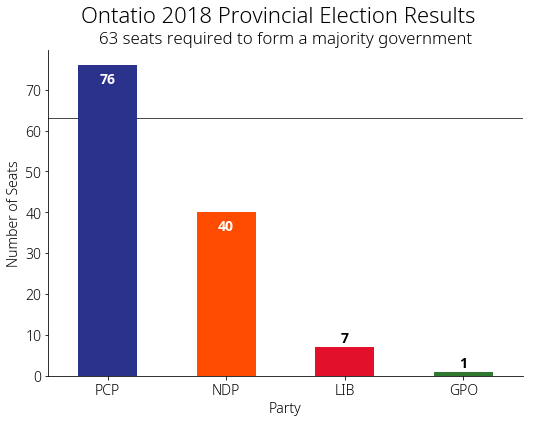

In [3]:
# What were the election counts
x = candidates.loc[candidates['Elected'], 'Party'].value_counts()
 
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel("Number of Seats")
plt.suptitle('Ontatio 2018 Provincial Election Results', size=22)
plt.title('63 seats required to form a majority government')

ax.axhline(63, color='black', zorder=-1, linewidth=0.7)

ax.get_figure().savefig('images/election-results.svg')

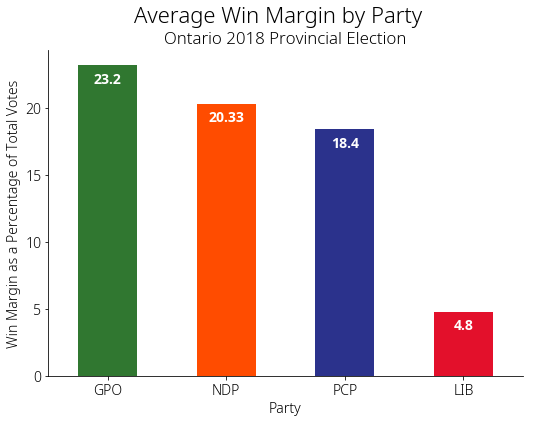

In [4]:
x = candidates.groupby('Party')['Win Margin Percent'].mean().dropna().round(2).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Win Margin as a Percentage of Total Votes')
plt.suptitle('Average Win Margin by Party', size=22)
plt.title('Ontario 2018 Provincial Election')


ax.get_figure().savefig('images/win-margin.svg', format='svg', pad_inches=1)

## Did the Green Party help the Progressive Conservative Party by splitting votes from the NDP?

In [5]:
runners_up = (candidates.loc[candidates['Elected'] == False]
              .sort_values('Votes Count', ascending=False)
              .drop_duplicates('Riding')
              .set_index('Riding')
              .sort_index())
green_candidates = candidates.loc[candidates['Party'] == 'GPO'].set_index('Riding')
winners = candidates.loc[candidates['Elected']].set_index('Riding')

In [6]:
# Candidates that would have lost had Green Party votes gone to the runner-up
diff_indicies = winners['Win Margin Count'].sub(green_candidates['Votes Count']) < 0
winners.loc[diff_indicies & (winners['Party'] == 'PCP')]

,Candidate Name,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
Riding,,,,,,,
Brampton West,Amarjot Sandhu,PCP,14951,39.4,True,490.0,1.3
Brantford—Brant,Willem Bouma,PCP,24437,42.0,True,635.0,1.1
Cambridge,Belinda Karahalios,PCP,17793,37.0,True,2154.0,4.5
Eglinton—Lawrence,Robin Martin,PCP,19999,40.4,True,957.0,1.9
Kitchener—Conestoga,Michael Harris,PCP,17005,39.6,True,686.0,1.6
Kitchener South—Hespeler,Amy Fee,PCP,16511,38.9,True,770.0,1.8
Ottawa West—Nepean,Jeremy Roberts,PCP,16590,32.8,True,175.0,0.3
Sault Ste. Marie,Rosario Romano,PCP,13498,42.0,True,414.0,1.3
Scarborough—Rouge Park,Vijayadhithyan Thanigasalam,PCP,16224,38.6,True,963.0,2.3


In [7]:
PCP_ridings = candidates.loc[(candidates['Party'] == 'PCP') & candidates['Elected'], 'Riding'].values
if_no_green_votes = pd.Series(runners_up.loc[(winners['Party'] == 'PCP'), 'Votes Count'].add(green_candidates['Votes Count']).values, index=runners_up['Candidate Name'], name='Votes Count')

candidates_no_green = candidates.copy().set_index('Candidate Name')
candidates_no_green.update(if_no_green_votes)
# Drop GPO candidate rows in PCP ridings
candidates_no_green = candidates_no_green[
    (~candidates_no_green['Riding'].isin(PCP_ridings)) |
    (candidates_no_green['Party'] != 'GPO')]

In [9]:
new_winners = candidates_no_green.sort_values('Votes Count', ascending=False).drop_duplicates('Riding')
new_winners.loc[new_winners['Elected'] == False]

,Riding,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
Candidate Name,,,,,,,
Alexandra Felsky,Brantford—Brant,NDP,26543.0,40.9,False,NaN,NaN
Michael Colle,Eglinton—Lawrence,LIB,20232.0,38.4,False,NaN,NaN
Kelly Dick,Kitchener—Conestoga,NDP,19172.0,38.0,False,NaN,NaN
Fitzroy Vanderpool,Kitchener South—Hespeler,NDP,18939.0,37.1,False,NaN,NaN
Marjorie Knight,Cambridge,NDP,18657.0,32.5,False,NaN,NaN
Chandra Pasma,Ottawa West—Nepean,NDP,18352.0,32.5,False,NaN,NaN
Felicia Samuel,Scarborough—Rouge Park,NDP,16275.0,36.3,False,NaN,NaN
Jagroop Pangli,Brampton West,NDP,15460.0,38.1,False,NaN,NaN
Michele McCleave-Kennedy,Sault Ste. Marie,NDP,14128.0,40.7,False,NaN,NaN


In [20]:
candidates.set_index('Riding').loc[winners.loc[diff_indicies & (winners['Party'] == 'PCP')].index]
candidates.loc[candidates['Elected'] & (candidates['Party'] == 'LIB')]

,Candidate Name,Riding,Party,Votes Count,Votes Percent,Elected,Win Margin Count,Win Margin Percent
139,Michael Coteau,Don Valley East,LIB,13012,35.9,True,1028.0,2.8
151,Kathleen Wynne,Don Valley West,LIB,17802,38.9,True,181.0,0.4
503,Marie-France Lalonde,Orléans,LIB,24972,39.0,True,2463.0,3.9
523,John Fraser,Ottawa South,LIB,20773,39.6,True,5454.0,10.4
529,Nathalie Des Rosiers,Ottawa—Vanier,LIB,20555,42.9,True,6323.0,13.2
633,Mitzie Hunter,Scarborough—Guildwood,LIB,11972,33.3,True,74.0,0.2
704,Michael Gravelle,Thunder Bay—Superior North,LIB,11973,39.9,True,813.0,2.7


In [ ]:
x = new_winners['Party'].value_counts()
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel("Number of Seats")
plt.suptitle('Ontatio 2018 Provincial Election Results\nWith GPO Votes Redistributed', size=22)
plt.title('63 seats required to form a majority government')

plt.tight_layout()
plt.subplots_adjust(top=0.83)

ax.axhline(63, color='black', zorder=-1, linewidth=0.7)


ax.get_figure().savefig('images/alt-results-no-green.svg', format='svg')

# Census Data

In [ ]:
census = candidates.set_index('Riding').join(pd.read_csv('formatted_census_data.csv', index_col=0))

def w_mean (df, col):
    parties = ['GPO', 'LIB', 'NDP', 'PCP']
    g = df.loc[df['Party'].isin(parties)].assign(w_means=lambda x: x[col] * x['Votes Count']).groupby('Party')
    return (g['w_means'].sum() / g['Votes Count'].sum()).rename(col)

In [ ]:
pop_columns = ['Pop. % 0-19', 'Pop. % 20-39', 'Pop. % 40-59', 'Pop. % 60-79', 'Pop. % 80-']
x = pd.concat([census.pipe(w_mean, pop) for pop in pop_columns], axis=1).reindex(index=['PCP', 'NDP', 'LIB', 'GPO'])

ax = x.plot.bar(figsize=(8.5,10), stacked=True, color=['#003030','#006060', '#007F7F', '#00AFAF', '#00D5D5'])

ymax = plt.ylim()[1]
unit = ymax/72

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for p in ax.patches:
    ax.annotate(p.get_height().round(2), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() - 0.5*unit),
                ha='center', va='top',
                size=14, weight=600, color='white')

for tick in ax.get_xticklabels():
    tick.set_rotation(0)
    
ax.legend(['Ages 0-19', 'Ages 20-39','Ages 40-59','Ages 60-79','Ages 80+'], framealpha=1, ncol=3, fancybox=False, loc='lower center')
ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average Percentage of Population')
plt.suptitle('Vote Weighted Party Age Demographics', size=22, y = 0.945)
plt.title('2018 Ontario Provincial Election')


ax.get_figure().savefig('images/party-age-demo.svg', format='svg')

In [ ]:
x = census.loc[census['Elected']].groupby('Party')['Pop Density (km^2)'].mean().round(1).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Population Density (people/km$^2$)')
plt.suptitle('Average Population Density of Elected Ridings', size=22)
plt.title('2018 Ontario Provincial Election')

ax.get_figure().savefig('images/party-pop-density.svg', format='svg')

In [ ]:
ax = census.loc[(census['Party'] == 'PCP') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Percent', figsize=(8.5,6),color='#2B328C')
census.loc[(census['Party'] == 'NDP') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Percent', color='#FF4C00', marker='*', ax=ax)
census.loc[(census['Party'] == 'LIB') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Percent', color='#E3102B', marker='^', ax=ax)
census.loc[(census['Party'] == 'GPO') & census['Elected']].plot.scatter(
    x='Pop Density (km^2)', y='Votes Percent', color='#307730', marker='s', ax=ax)

ax.legend(['PCP','NDP','LIB','GPO'], framealpha=1, ncol=1, fancybox=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Population Density (people/km$^2$)')
ax.set_ylabel('Percentage of Total Riding Votes')
ax.set_xscale('log')

plt.suptitle('Party Votes by Riding Density', size=22)
plt.title('2018 Ontario Provincial Election')


ax.get_figure().savefig('images/pop-density-scatter.svg', format='svg')

In [ ]:
x = census.pipe(w_mean, '% Married/Common Law').round(2).sort_values(ascending=False)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average of \n % Married/Common Law Voters')
plt.suptitle('Average Percentage of Married/Common Law Voters', size=22)
plt.title('2018 Ontario Provincial Election')

In [ ]:
x = census.pipe(w_mean, 'Household Med. Income').sort_values(ascending=False)
ax = plotBarStyled(x, '${:,.2f}'.format, 0.8, 60000)

ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average of\nRiding Household Median Income')

plt.suptitle('Average Household Income by Party', size=22)
plt.title('2018 Ontario Provincial Election')


ax.get_figure().savefig('images/party-average-income.svg', format='svg')

In [ ]:
x = census.loc[census['Party'] == 'PCP']
ax = sns.regplot(x['Household Med. Income'], x['Votes Percent'], order=1, color='#2B328C')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ridings = x['Household Med. Income'].dropna().index
m, b, r, p, err = scipy.stats.linregress(x.loc[ridings, 'Household Med. Income'], x.loc[ridings, 'Votes Percent'])
ax.text(100000, 62, "r$^2$ = " + str(round(r**2, 4)), fontsize = 14)

ax.set_xlabel('Median Household Income')
ax.set_ylabel('Percentage of Vote')

plt.suptitle('Income vs Percentage of Vote', size=18)
plt.title('Progressive Conservative Party of Ontario (2018 Election)', size=12)

plt.subplots_adjust(top=0.85, left=0.1)

ax.get_figure().savefig('images/pcp-income.svg', format='svg')

plt.show()

In [ ]:
x = census.loc[census['Party'] == 'NDP']
ax = sns.regplot(x['Household Med. Income'], x['Votes Percent'], order=1, color='#FF4C00')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
m, b, r, p, err = scipy.stats.linregress(x.loc[ridings, 'Household Med. Income'], x.loc[ridings, 'Votes Percent'])
ax.text(105000, 40, "r$^2$ = " + str(round(r**2, 4)), fontsize = 14)

ax.set_xlabel('Median Household Income')
ax.set_ylabel('Percentage of Vote')

plt.suptitle('Income vs Percentage of Vote', size=18)
plt.title('Ontario New Democratic Party (2018 Election)', size=12)

plt.subplots_adjust(top=0.85, left=0.1)

ax.get_figure().savefig('images/ndp-income.svg', format='svg')

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(16,6))


pcp = census.loc[census['Party'] == 'PCP']
sns.regplot(pcp['Household Med. Income'], pcp['Votes Percent'], order=1, color='#2B328C', ax=ax1)

ridings = pcp['Household Med. Income'].dropna().index

m, b, r, p, err = scipy.stats.linregress(pcp.loc[ridings, 'Household Med. Income'], pcp.loc[ridings, 'Votes Percent'])
ax1.text(100000, 62, "r$^2$ = " + str(round(r**2, 4)), fontsize = 14)

ax1.set_title('Progressive Conservative Party of Ontario', size=14)
ax1.set_xlabel('Median Household Income')
ax1.set_ylabel('Percentage of Vote')


ndp = census.loc[census['Party'] == 'NDP']
sns.regplot(ndp['Household Med. Income'], ndp['Votes Percent'], order=1, color='#FF4C00', ax=ax2)

m, b, r, p, err = scipy.stats.linregress(ndp.loc[ridings, 'Household Med. Income'], ndp.loc[ridings, 'Votes Percent'])
ax2.text(105000, 40, "r$^2$ = " + str(round(r**2, 4)), fontsize = 14)

ax2.set_title('Ontario New Democratic Party', size=14)
ax2.set_xlabel('Median Household Income')
ax2.set_ylabel('Percentage of Vote')


plt.suptitle('Income vs Percentage of Vote (2018 Ontario Provincial Election)', size=18)
fig.savefig('images/income-v-votes.svg', format='svg')

In [ ]:
x = census.pipe(w_mean, '% Immigrant').sort_values(ascending=False).round(2)
ax = plotBarStyled(x)

ax.set_xlabel('Party')
ax.set_ylabel('Vote Weighted Average of\nImmigrant Percentage')

plt.suptitle('Average Immigrant Percentage of Riding Population by Party', size=22)
plt.title('2018 Ontario Provincial Election')

ax.get_figure().savefig('images/party-immigrant.svg', format='svg')